### TimeGAN example using basis functions

The purpose of this notebook is to demonstrate all the steps required to be able
to train and use TimeGAN model from `ydata-synthetic` repo.

Please check that all dependencies from `requirements.txt` are installed.
GPU usage is recommended.

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import os
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import plotly.express as px

from ydata_synthetic.synthesizers.timeseries import TimeGAN
from ydata_synthetic.synthesizers import ModelParameters

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from sequences import sliding_window, split_sequence2Xy
from plotting import plot_sample_sequences, plot_pca_vs_tsne, plot_rnn_forecast
from forecast import get_rnn_forecaster
from metrics import calculate_metrics


tf.random.set_seed(42)

In [35]:
MODELS_DIR = 'models'
MODEL_NAME = 'tgan_simple_functions_1500_32_good.pkl'

MODEL_PATH = os.path.join(MODELS_DIR, MODEL_NAME)
TRAINING_STEPS = 1500
SEQUENCE_LENGTH = 32


RNN_UNITS = 32
RNN_EPOCHS = 100
RNN_BATCH_SIZE = 64

## Step 1: Load data

In our case, we generate a couple of simple 1-dimentional functions samples:

* Constant
* Sin
* Cos

The idea is that any complex model should be able to capture such simple patterns.

In [4]:
n_samples = 10000
linear = np.linspace(0, 1000, num=n_samples)
cos = np.cos(linear)
sin = np.sin(linear)
constant = np.ones((n_samples, ))

In [5]:
X = pd.DataFrame(np.vstack((constant, sin, cos)).T, columns=['constant', 'sin(x)', 'cos(x)'])
X.head()

constant    sin(x)    cos(x)
0       1.0  0.000000  1.000000
1       1.0  0.099843  0.995003
2       1.0  0.198689  0.980063
3       1.0  0.295549  0.955328
4       1.0  0.389455  0.921045

## Step 2: Data preprocessing

### a.Train-test split

Please note that train-test split is, in general, not required, as this model is self-supervised.

However, if you're going to train classifier based on augmented data, you should split train and test.

This will ensure you do not expose test data to the data augmentation process, which otherwise would lead to overoptimistic results.

In [6]:
Xtr, Xte = train_test_split(X, test_size=.33, shuffle=False, random_state=42)

### b. Perform scaling

In [7]:
scaler = MinMaxScaler()

Xtr_scaled = scaler.fit_transform(Xtr)
Xte_scaled = scaler.transform(Xte)

### c. Create slices of time-series to train model

Notice that we use this function later on, when we specify sequence length.

## Step 3: Define parameters and train a model

Since documentation is scarse, we explain some of the parameters below:

* `n_seq`: amount of features (columns) in your dataset
* `seq_len`: sliding window size (basically amount of consecutive samples considered at once)

* `training_steps`: amount of epochs to train models.

Observation on `train_steps`: you need at least 1000 training steps to get reasonable results

In [8]:
model_params = ModelParameters(layers_dim=16, noise_dim=32)

hidden_dim = 16
n_features = len(X.columns)
gamma = 1

In [9]:
gan = TimeGAN(model_params, hidden_dim, SEQUENCE_LENGTH, n_features, gamma)

2022-05-13 11:59:15.843595: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [10]:
train_sequences = sliding_window(Xtr_scaled, SEQUENCE_LENGTH)
train_sequences.shape

(6668, 32, 3)

In [11]:
test_sequences = sliding_window(Xte_scaled, SEQUENCE_LENGTH)
test_sequences.shape

(3268, 32, 3)

In [12]:
np.random.seed(42)
np.random.shuffle(train_sequences)

Let's plot some examples to see how it looks. We expect samples from the trained model to look similarly.

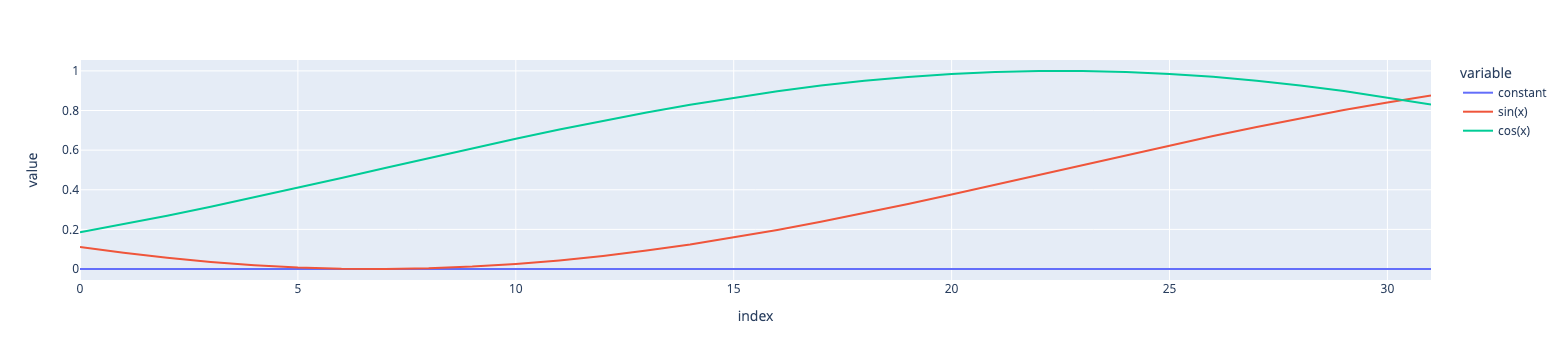

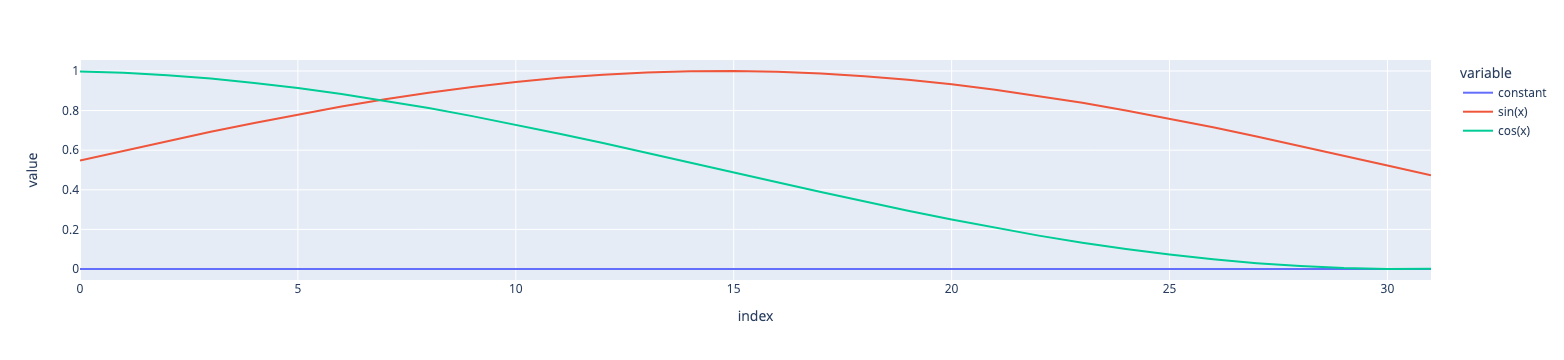

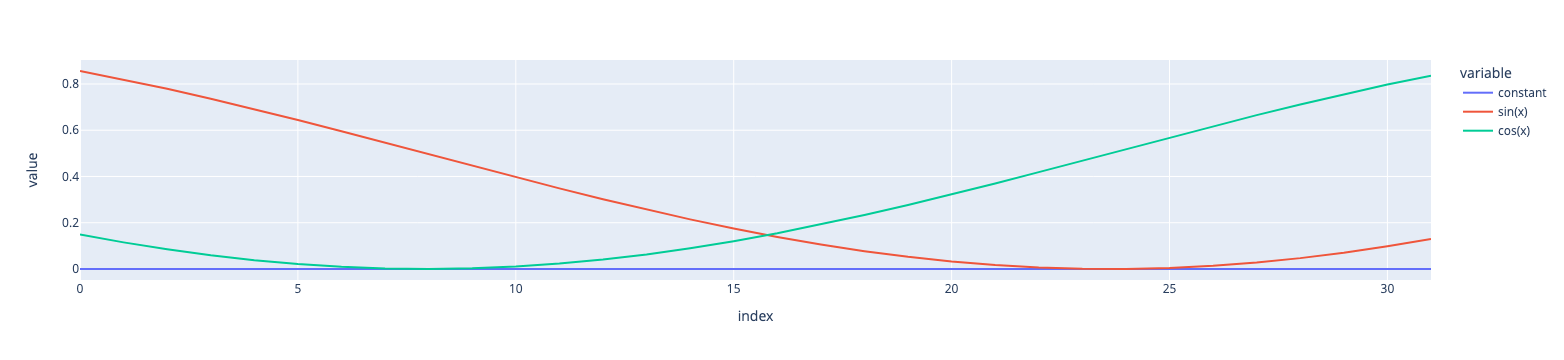

In [13]:
plot_sample_sequences(train_sequences, columns=X.columns)

In [14]:
if not os.path.exists(MODEL_PATH):
    gan.train(train_sequences, TRAINING_STEPS)
    gan.save(MODEL_PATH)
else:
    print('loading model from cache:', MODEL_PATH)
    gan = gan.load(MODEL_PATH)

loading model from cache: tgan_simple_functions_1500_32_good.pkl


2022-05-13 11:59:16.858319: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Step 4: Generate samples

Notice, that at least one full batch is generated, regardless what the input to `model.sample()` is.

In [15]:
samples = gan.sample(len(train_sequences))

Synthetic data generation: 100%|███████████████████████████████████████████████████████████████████████| 53/53 [00:10<00:00,  5.17it/s]


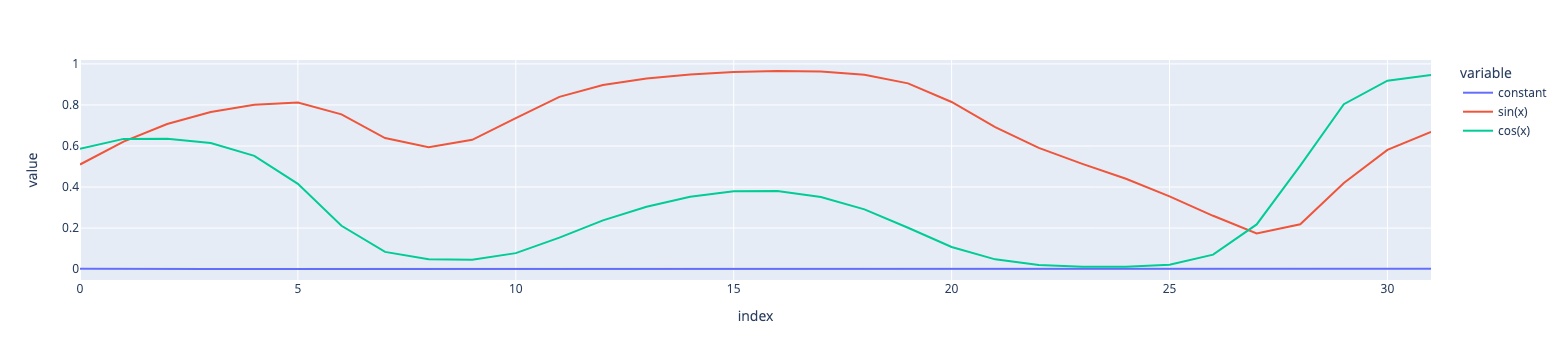

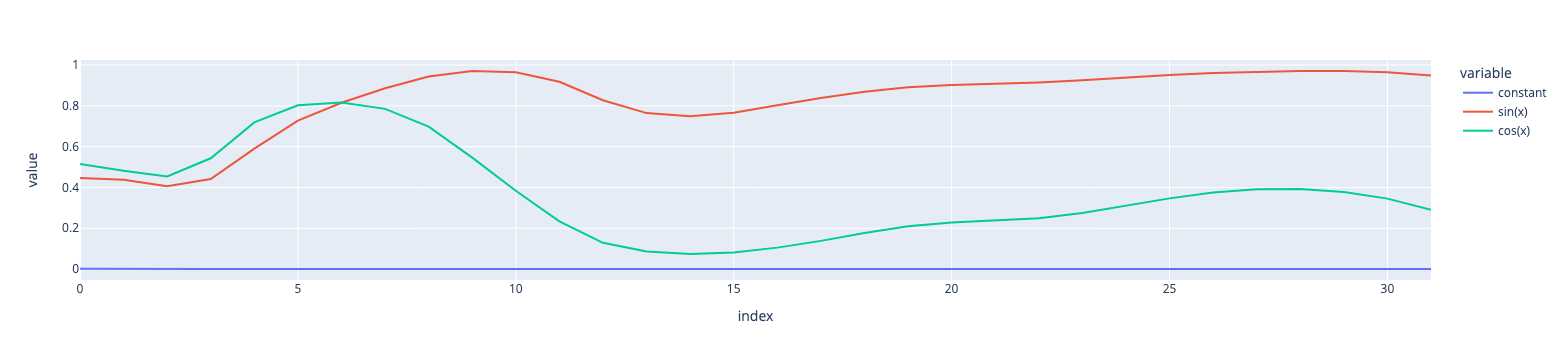

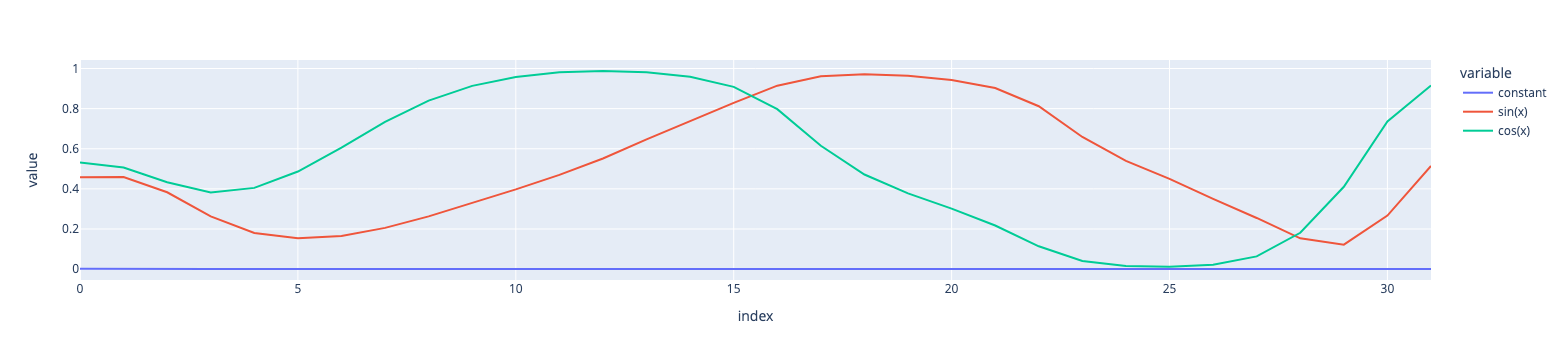

In [16]:
plot_sample_sequences(samples, columns=X.columns)

## Step 5: Compare distribution statistics of real and synthetic data

# a: by looking at 2D projections comparison

Here we:
1. Sample the real and synthetic data
2. Train pca on real data, transform both real and synthetic
3. Build t-SNE projection using the same logic

The idea here is that, if data distribution is preserved, then by using a basis of real data principal components, synthetic data should arrange itself in the similar, compact representation.

/Users/ptysh/nilm/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



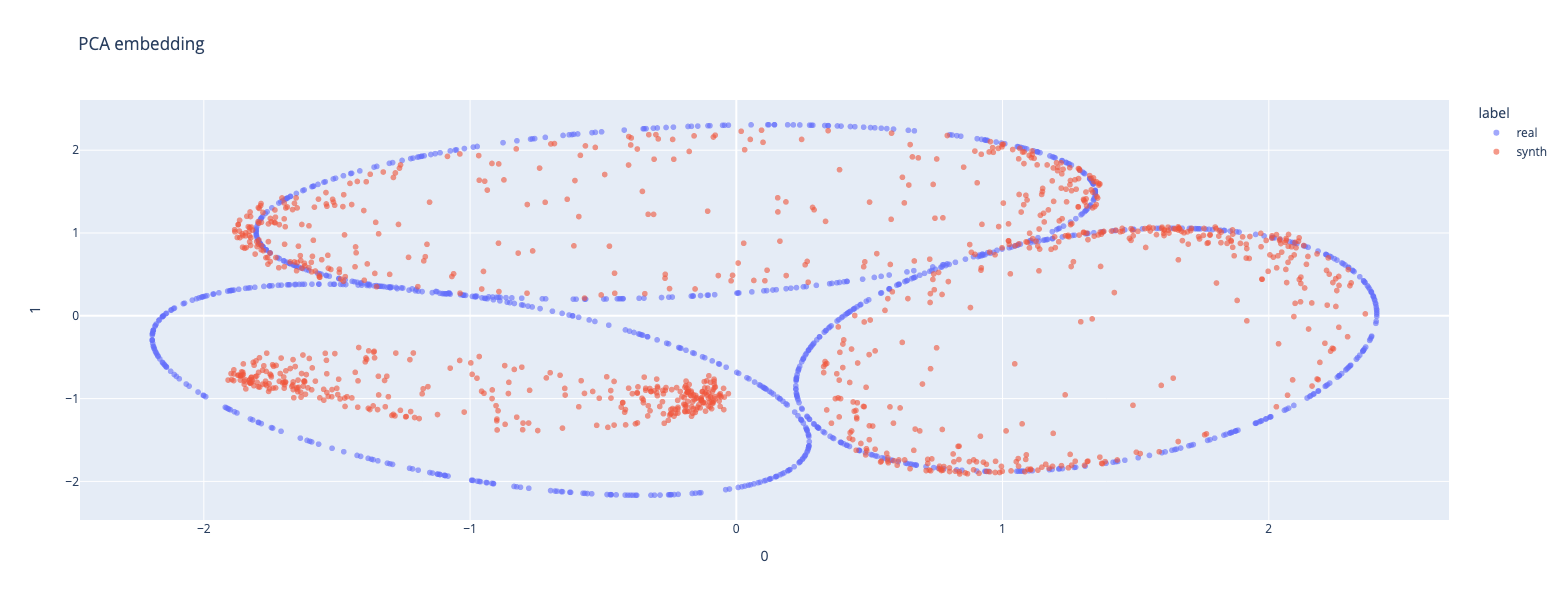

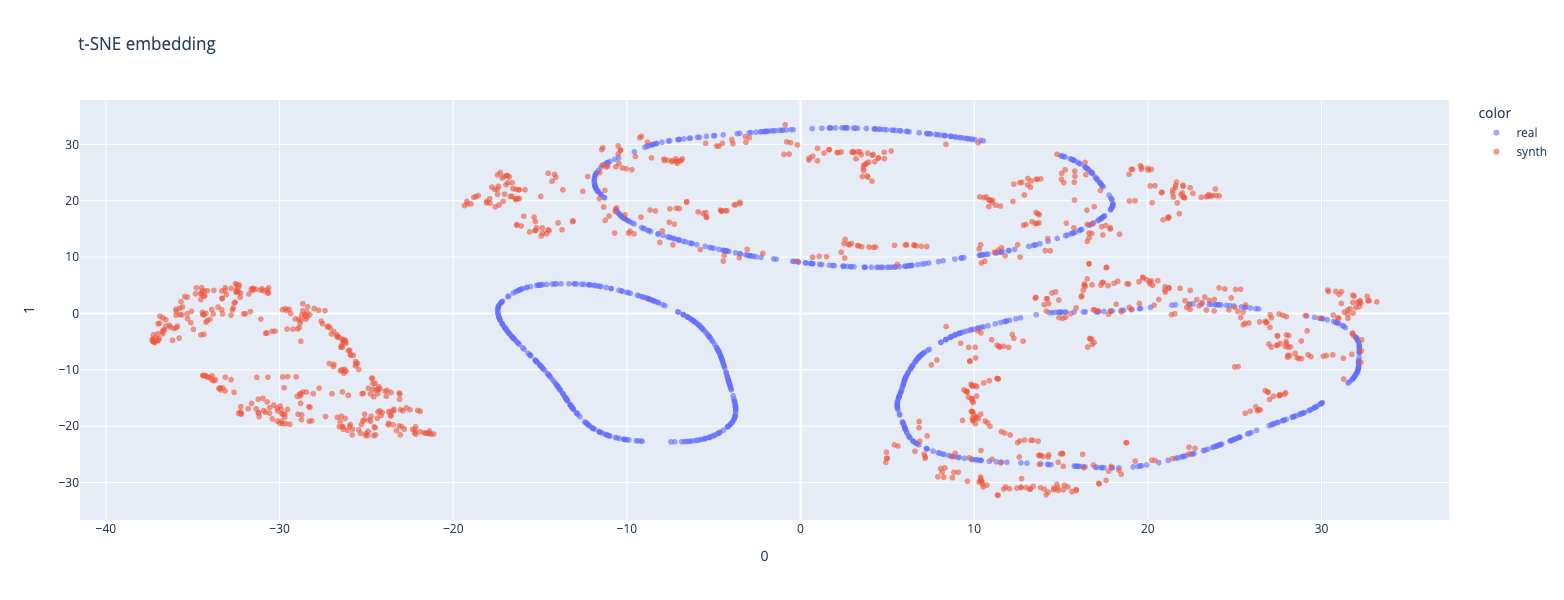

In [17]:
plot_pca_vs_tsne(train_sequences, samples)

### b. By comparing identical models trained on real vs synth data

Now, assuming we have already generated sequences of size `sequence_len`, we can split each sequence into `train_sequence = sequence[:sequence_len-1]` and target `train_target = sequence[sequence_len]`

In [18]:
real_w_synth = np.concatenate([train_sequences, samples])
np.random.seed(42)
real_w_synth = np.random.permutation(real_w_synth)

In [19]:
X_real_train, y_real_train = split_sequence2Xy(train_sequences)

# we will use the same test sequences for synth-based model too
X_real_test, y_real_test = split_sequence2Xy(test_sequences)

X_synth_train, y_synth_train = split_sequence2Xy(samples)

X_cmb_train, y_cmb_train = split_sequence2Xy(real_w_synth)

In [20]:
print(f'Synthetic X train: {X_synth_train.shape}, y train: {y_synth_train.shape}')
print(f'Real X train: {X_real_train.shape}, y train: {y_real_train.shape}')
print(f'Combined Real and synth X train: {X_cmb_train.shape}, y train: {y_cmb_train.shape}')

print(f'Real X test: {X_real_test.shape}, y test: {y_real_test.shape}')

Synthetic X train: (6784, 31, 3), y train: (6784, 3)
Real X train: (6668, 31, 3), y train: (6668, 3)
Combined Real and synth X train: (13452, 31, 3), y train: (13452, 3)
Real X test: (3268, 31, 3), y test: (3268, 3)


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [22]:
ts_real = get_rnn_forecaster(RNN_UNITS, n_features, name='Real_RNN', input_shape=X_real_train.shape)
ts_synth = get_rnn_forecaster(RNN_UNITS, n_features, name='Synth_RNN', input_shape=X_real_train.shape)
ts_cmb = get_rnn_forecaster(RNN_UNITS, n_features, name='Real_Synth_RNN', input_shape=X_real_train.shape)

In [23]:
ts_real.summary()

Model: "Real_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN_1_relu (GRU)             (None, 31, 32)            3552      
_________________________________________________________________
RNN_2_linear (GRU)           (None, 32)                6336      
_________________________________________________________________
OUT_sigmoid (Dense)          (None, 3)                 99        
Total params: 9,987
Trainable params: 9,987
Non-trainable params: 0
_________________________________________________________________


In [24]:
real_train = ts_real.fit(x=X_real_train,
                          y=y_real_train,
                          validation_data=(X_real_test, y_real_test),
                          epochs=RNN_EPOCHS,
                          batch_size=RNN_BATCH_SIZE,
                          callbacks=[early_stopping],
                          verbose=0)

### Tip for Synthetic-based RNN forecast

Be careful with early stopping, it can happen preliminary for synthetic data, which is not the case for real data.

In [25]:
#Training the model with the synthetic data

synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_real_test, y_real_test),
                          epochs=RNN_EPOCHS,
                          batch_size=RNN_BATCH_SIZE,
                          callbacks=[early_stopping],
                          verbose=0)

In [26]:
#Training the model with the combined real and synthetic data
cmb_train = ts_cmb.fit(x=X_cmb_train,
                          y=y_cmb_train,
                          validation_data=(X_real_test, y_real_test),
                          epochs=RNN_EPOCHS,
                          batch_size=RNN_BATCH_SIZE,
                          callbacks=[early_stopping],
                          verbose=0)

In [27]:
#Summarize the metrics here as a pandas dataframe
real_predictions = ts_real.predict(X_real_test)
synth_predictions = ts_synth.predict(X_real_test)
cmb_predictions = ts_cmb.predict(X_real_test)

real_pred_df = pd.DataFrame(real_predictions, columns=X.columns)
synth_pred_df = pd.DataFrame(synth_predictions, columns=X.columns)
cmb_pred_df = pd.DataFrame(cmb_predictions, columns=X.columns)

In [28]:
calculate_metrics(y_real_test, real=real_predictions, synth=synth_predictions, combined=cmb_predictions)

real  synth  combined
r2    0.666  0.652     0.666
MAE   0.006  0.026     0.006
RMSE  0.007  0.035     0.007

Now let's look at visual representation of predictions

### Test predictions for RNN based on real data:

In [29]:
first_n_samples = 100

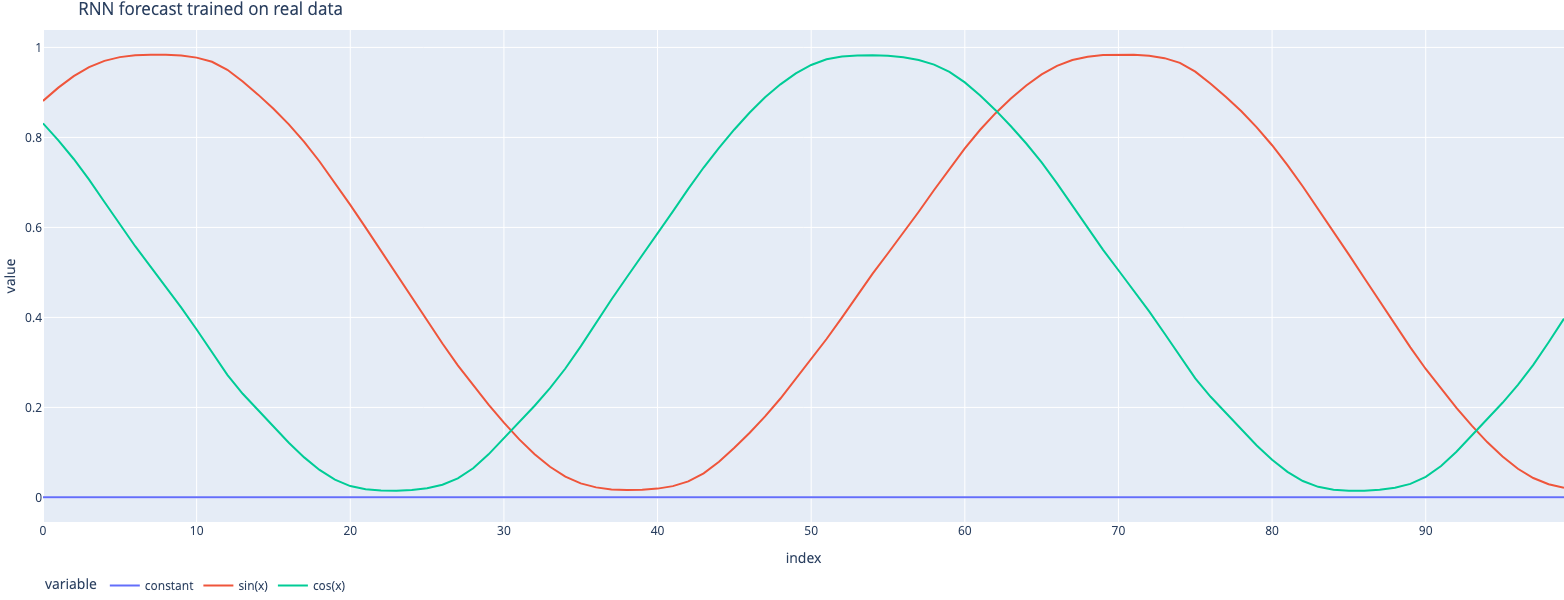

In [30]:
plot_rnn_forecast(real_pred_df.iloc[:first_n_samples], title='RNN forecast trained on real data')

### Test predictions for RNN based only on synth data:

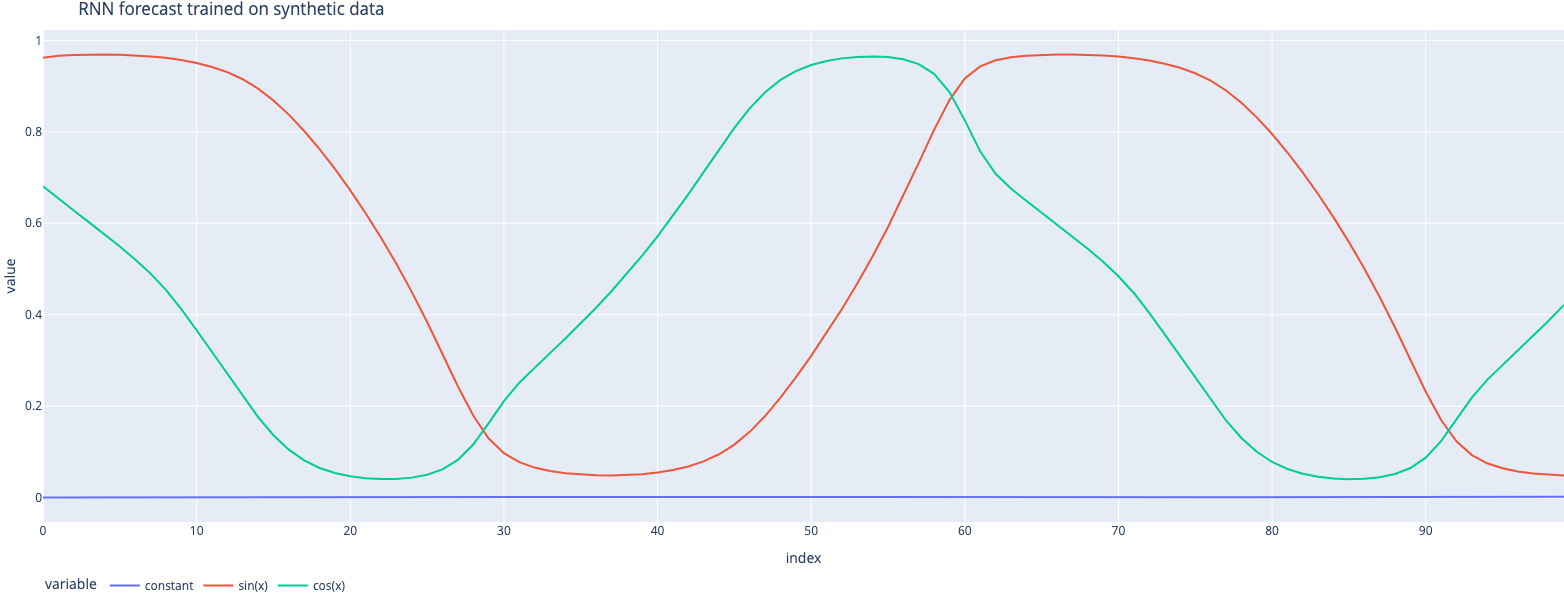

In [31]:
plot_rnn_forecast(synth_pred_df.iloc[:first_n_samples], title='RNN forecast trained on synthetic data')

### Test predictions of RNN trained on both real and synth data:

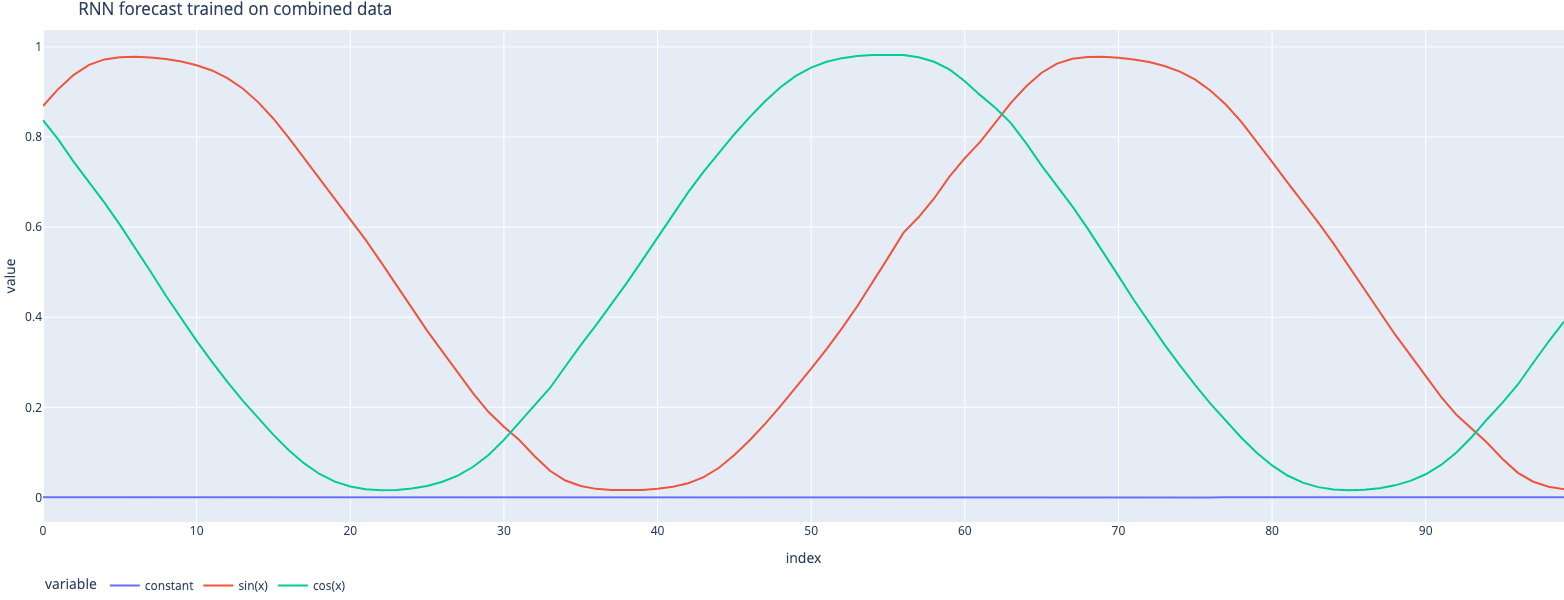

In [32]:
plot_rnn_forecast(cmb_pred_df.iloc[:first_n_samples], title='RNN forecast trained on combined data')